<a href="https://colab.research.google.com/github/catarina-moreira/causabilityXAi/blob/master/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Predictive Black-Box Models: An Interpretable Probabilistic Approach

Catarina Moreira, Yu-Liang Chou, Mythreyi Velmurugan, Renuka Sindhgatta Rajan, Chun Ouyang, Peter Bruza

**Abstract** 


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# login into my google drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

learning_lib = drive.CreateFile( {'id' : '1wwSN3AIl_dmayKENu5jnc1BRaNPe8BZc'}).GetContentFile("learning.py")


In [ ]:
# Install tensorflow
try:
    # tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

In [ ]:
# for reproduciability reasons:
import numpy as np
import pandas as pd
import random as rn
import time

%matplotlib inline

# import auxiliary functions
from learning import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Diabetes Dataset

**Context**
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the 
- number of pregnancies the patient has had, 
- their BMI, 
- insulin level, 
- age,
- glucose,
- blood pressure,
- skin thickness,
- Diabetes pedigree function


### Checking Dataset

In [ ]:
# path to project folder
PATH = "/content/drive/My Drive/Colab Notebooks/DDS/"


In [ ]:
# name of dataset
DATASET_NAME = "diabetes.csv"

# variable containing the class labels in this case the dataset contains:
# 0 - if not diabetes
# 1 - if diabetes
class_var = "Outcome"

# load dataset
dataset_path = PATH + "datasets/" + DATASET_NAME
data = pd.read_csv( dataset_path )


In [ ]:
# features
feature_names = data.drop([class_var], axis=1).columns.to_list()

# check how balanced the classes are
data.groupby(class_var).count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


### Balanced Dataset

In [ ]:
# balance dataset
sampled_data = data.sample(frac=1)
sampled_data = sampled_data[ sampled_data["Outcome"] == 0]
no_data = sampled_data.sample(frac=1)[0:268]

yes_data = data[ data["Outcome"] == 1]

balanced_data = [no_data,yes_data]
balanced_data = pd.concat(balanced_data)

# check how balanced the classes are
balanced_data.groupby(class_var).count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,268,268,268,268,268,268,268,268
1,268,268,268,268,268,268,268,268


#### Train a Model for the Balanced Dataset

In [ ]:
# apply one hot encoder to data
# standardize the input between 0 and 1
X, Y, encoder, scaler = encode_data( data, class_var)

n_features = X.shape[1]
n_classes = len(data[class_var].unique())
 
flag = False  # DO NOT CHANGE! Data has already been generated. 
if flag:
    # save training, test and validation data
    generate_save_training_data( dataset_path, X, Y)
    # load data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
else:
    # load existing training data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
    

In [ ]:
# generate models for grid search
if flag:
    models = grid_search_model_generator( n_features, n_classes )

    # perform grid_search
    HISTORY_DICT = perform_grid_search( models, PATH, DATASET_NAME.replace(".csv",""), 
                                   X_train, Y_train, 
                                   X_validation, Y_validation, X_test, Y_test, 
                                   batch_size=8, epochs=150 )

In [ ]:
path_serialisation_model = PATH + "training/" + DATASET_NAME.replace(".csv", "") + "/model/" 
path_serialisation_histr = PATH + "training/" + DATASET_NAME.replace(".csv", "") + "/history/" 

# the best performing model was obtained with 5 hidden layers with 12 neurons each
model_name = "model_h5_N12"
    
if flag:
    
    # get respective model training history and model
    model_history = HISTORY_DICT[ model_name ][0]
    model = HISTORY_DICT[ model_name ][1]

    # save model and model history to file
    save_model_history(  model_history, model_name, path_serialisation_histr )
    save_model( model, model_name, path_serialisation_model )
    
    model_history = load_model_history( model_name, path_serialisation_histr )
    model = load_model( model_name, path_serialisation_model )
else:
    model_history = load_model_history( model_name, path_serialisation_histr )
    model = load_model( model_name, path_serialisation_model )
    
model.summary()

Loaded model from disk
Model: "model_h5_N12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 12)                108       
_________________________________________________________________
dense_294 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_295 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_296 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_297 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_298 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_299 (Dense)            (N

#### Evaluate Model

In [ ]:
# evaluate loaded model on test and training data
optim = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)

print('\n[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))

4/4 [==============================] - 0s 3ms/step - loss: 0.4894 - accuracy: 0.7565

[Accuracy] Train: 0.715, Test: 0.757
[Loss] Train: 0.527, Test: 0.489


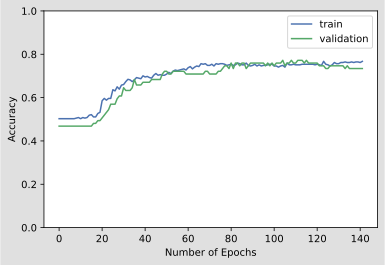

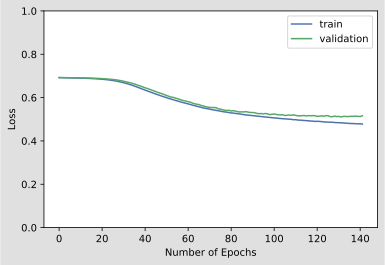

In [ ]:
plot_model_history( model_history, 'Accuracy' )
plot_model_history( model_history, 'Loss' )


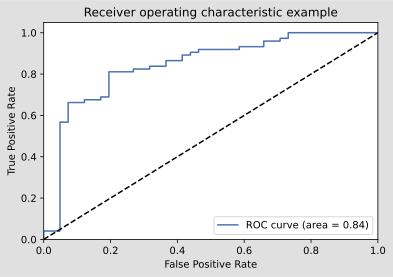

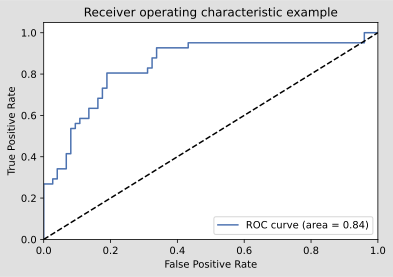

In [ ]:
#plot ROC curve
plot_ROC_Curve( model, X_test, Y_test, n_classes)

